In [20]:
# Prediction of the strength of cement treated soils using Optimized XGB model

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn.ensemble
import sklearn.tree
import xgboost as xgb
import shap

from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [21]:
# loading the cement-treated soils database
data = pd.read_csv('Data (Cement-treated soils).csv')
print(data.head())

      LL    FC    SC     ρnorm     ωnorm  C  T      η/Civ        qu  CEM
0  50.82  65.0  35.0  1.011940  1.034483  9  7   8.032423  1884.521  III
1  50.82  65.0  35.0  0.928358  1.241379  9  7  10.033080  1444.943  III
2  50.82  65.0  35.0  0.835821  1.758621  9  7  12.714820  1010.290  III
3  50.82  65.0  35.0  1.011940  1.000000  7  7  10.088880  1594.547  III
4  50.82  65.0  35.0  0.928358  1.275862  7  7  12.613960  1062.005  III


In [22]:
# One-hot encoding to convert cement types (catagories) into binary values.
df=pd.DataFrame(data=data)
df['CEM'].unique()
ohe_cement = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
OHE_transform_cement = ohe_cement.fit_transform(df[['CEM']])
df = pd.concat([data, OHE_transform_cement], axis=1).drop(columns=['CEM'])
df.head(5)


,LL,FC,SC,ρnorm,ωnorm,C,T,η/Civ,qu,CEM_I,CEM_II,CEM_III
0,50.82,65.0,35.0,1.011940,1.034483,9,7,8.032423,1884.521,0.0,0.0,1.0
1,50.82,65.0,35.0,0.928358,1.241379,9,7,10.033080,1444.943,0.0,0.0,1.0
2,50.82,65.0,35.0,0.835821,1.758621,9,7,12.714820,1010.290,0.0,0.0,1.0
3,50.82,65.0,35.0,1.011940,1.000000,7,7,10.088880,1594.547,0.0,0.0,1.0
4,50.82,65.0,35.0,0.928358,1.275862,7,7,12.613960,1062.005,0.0,0.0,1.0


In [23]:
# Defining input (X) and ouput (y) variables
X = df[['LL','FC','CEM_I','CEM_II','CEM_III','ρnorm', 'ωnorm','C','T', 'η/Civ']]
y = df['qu']

In [24]:
# Defining the XGBRegressor algorithm for XGB model development
model = xgb.XGBRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

# Defining the hyperparameter grid and searching for the optimal hyperparameter values using Grid search algorithm
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3,0.4],
    'n_estimators': [50, 100, 150, 200],
    'min_child_weight': [7],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.5, 0.6,0.7, 0.8],
    'reg_lambda': [0.3, 0.4, 0.5, 0.6]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Fit the model with the best hyperparameters
optimized_model = xgb.XGBRegressor(**best_params)
optimized_model.fit(X_train, y_train)

# Evaluate the best model on the test set
test_score = optimized_model.score(X_test, y_test)
print("Optimized model test set score:", test_score)
print("Optimized hyperparameter values:", best_params)

Optimized model test set score: 0.9748139133259395
Optimized hyperparameter values: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 150, 'reg_lambda': 0.6, 'subsample': 0.8}


In [25]:
# Define an additional metric - Mean Absolute Percentage Error (MAPE)
def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / abs(true))

In [26]:
# Training and testing evaluation of the model
Z_1 = optimized_model.predict(X_train)
Z_2 = optimized_model.predict(X_test)

print("Training R2:", r2_score(y_train, Z_1), "RMSE:", np.sqrt(mean_squared_error(y_train, Z_1)), "MAE:", mean_absolute_error(y_train, Z_1), "MAPE:", MAPE(y_train, Z_1)*100,"%")
print("Testing R2:", r2_score(y_test, Z_2), "RMSE:", np.sqrt(mean_squared_error(y_test, Z_2)), "MAE:", mean_absolute_error(y_test, Z_2), "MAPE:", MAPE(y_test,Z_2)*100,"%")

Training R2: 0.9953909649965591 RMSE: 86.93944160072601 MAE: 63.88357558913251 MAPE: 6.186094629667182 %
Testing R2: 0.9748139133259395 RMSE: 231.70623620591317 MAE: 152.0748322388858 MAPE: 16.685437467942638 %


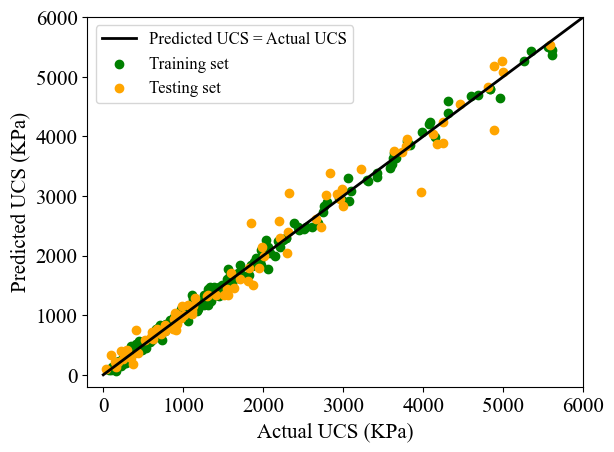

In [27]:
# Scattered plot of the actual vs predicted UCS values
xx = np.linspace(0, 6000, 100)
yy = xx
plt.figure()
plt.plot(xx, yy, color='black', linewidth=2)
plt.scatter(y_train, Z_1, marker='o', color='green')
plt.scatter(y_test, Z_2, marker='o', color='orange')
plt.tick_params (axis='both',which='major',labelsize=15)
plt.yticks(fontproperties = 'Times New Roman', size = 15)
plt.xticks(fontproperties = 'Times New Roman', size = 15)
font1 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 15,}
plt.axis('tight')
plt.xlabel('Actual UCS (KPa)', font1)
plt.ylabel('Predicted UCS (KPa)', font1)
plt.xlim([-200, 6000])
plt.ylim([-200, 6000])
plt.legend(['Predicted UCS = Actual UCS','Training set','Testing set'], loc = 'upper left', prop={'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 12,})
plt.show()

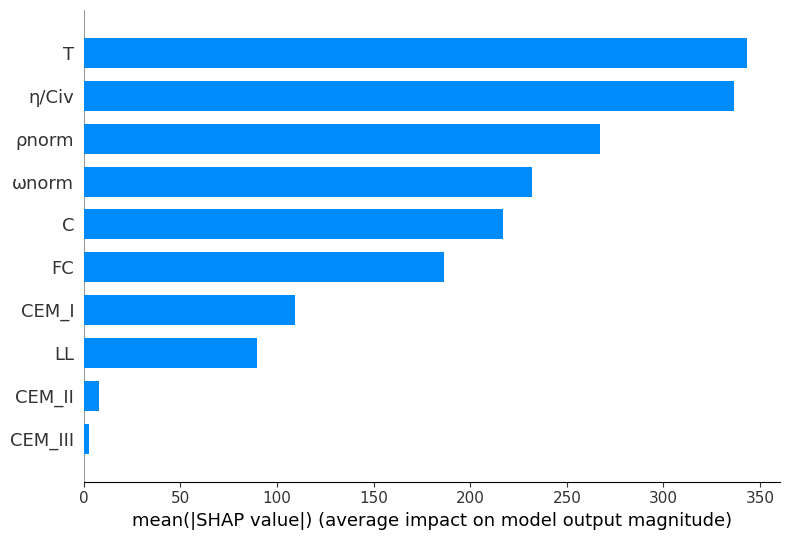

In [28]:
# Calculate mean absolute SHAP values of the features (Average impact on the model output)
X_shap = pd.DataFrame(X, columns = X.columns)
explainer = shap.Explainer(optimized_model)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap, plot_type="bar")

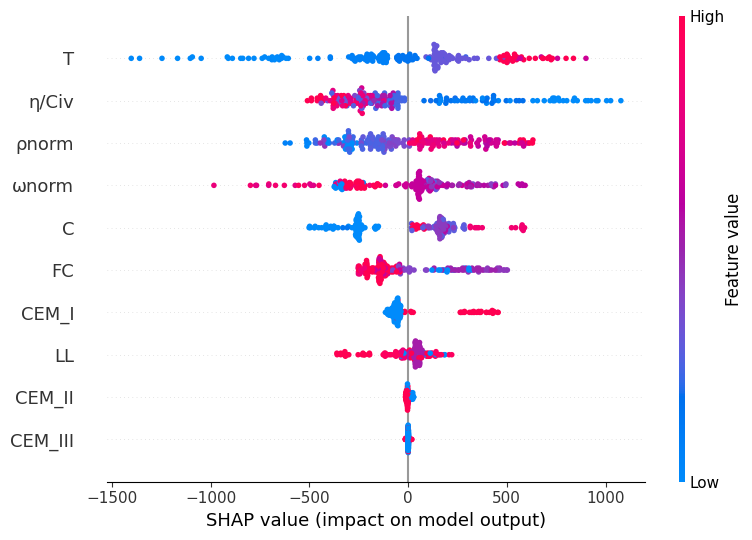

In [29]:
# SHAP summary plot of the input features
explainer = shap.Explainer(optimized_model, X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

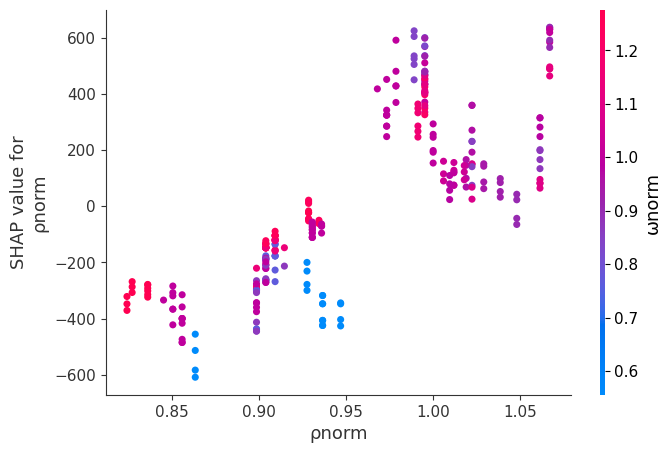

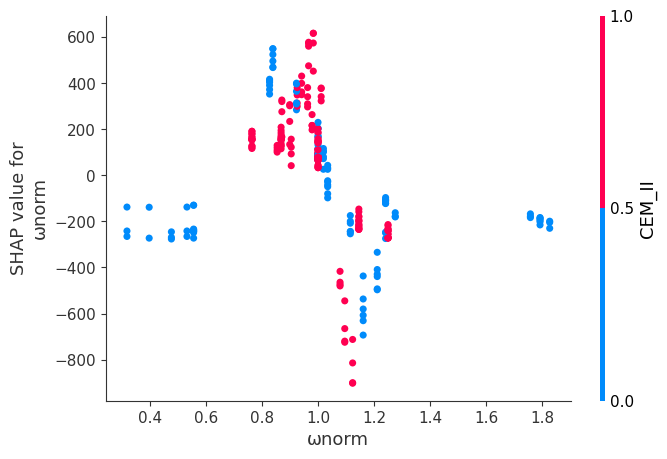

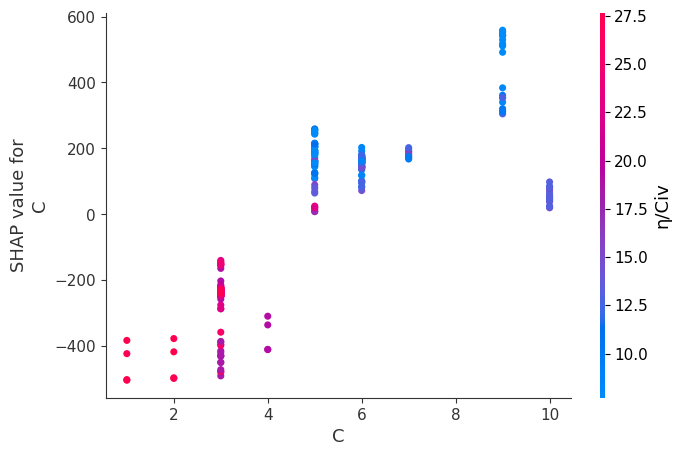

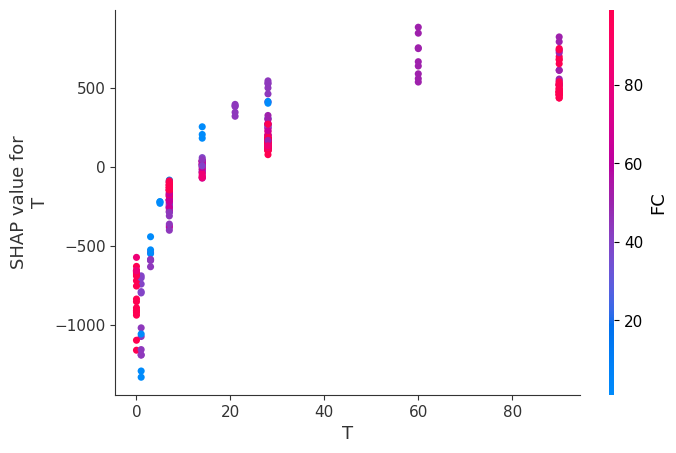

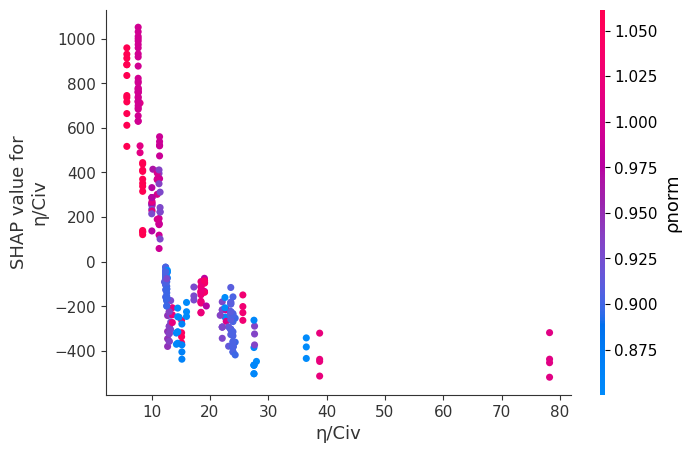

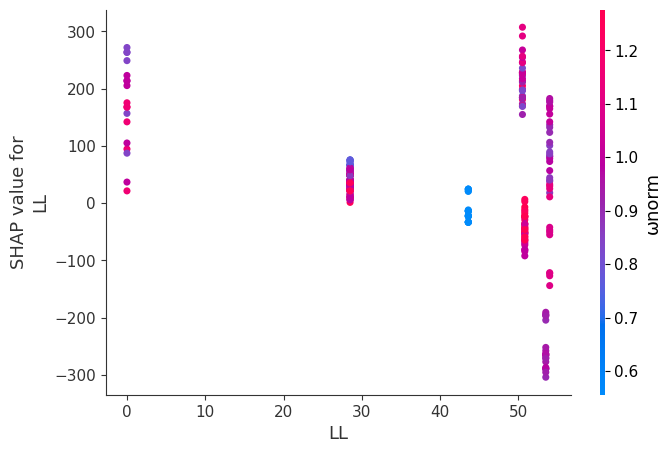

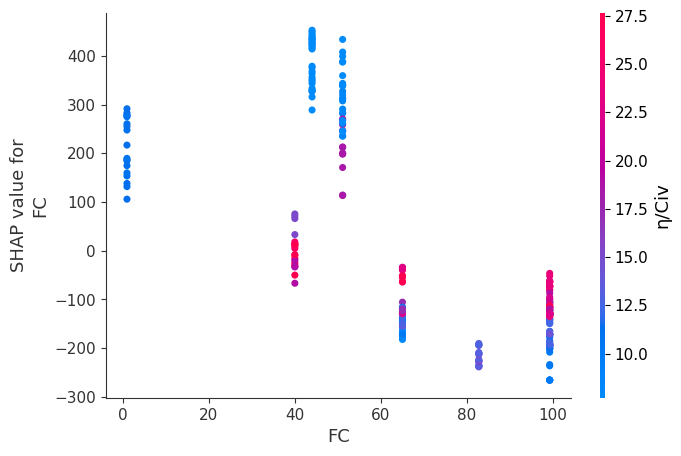

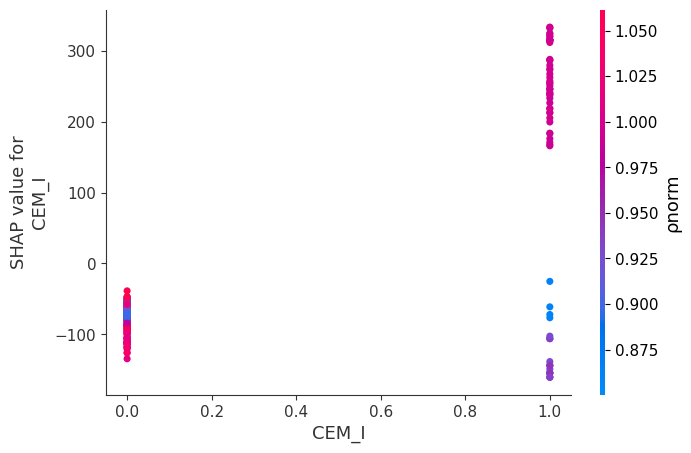

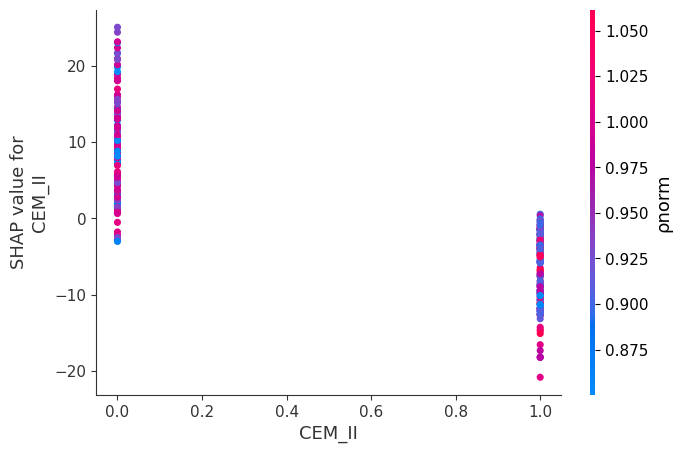

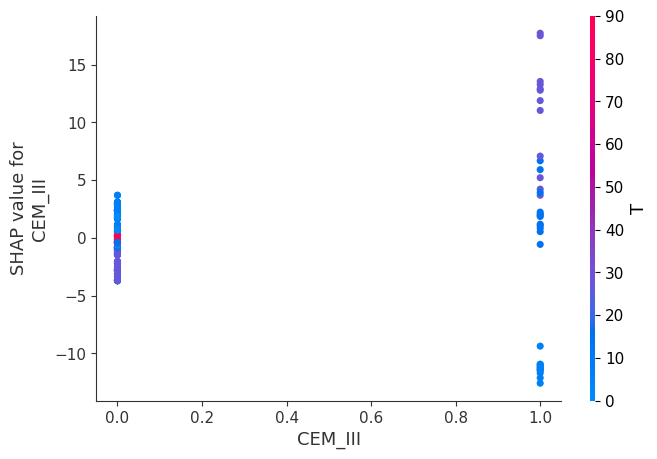

In [30]:
# SHAP dependence plots of the input features 
explainer = shap.TreeExplainer(optimized_model)
shap_values = explainer.shap_values(X)
shap.dependence_plot ('ρnorm', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('ωnorm', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('C', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('T', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('η/Civ', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('LL', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('FC', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('CEM_I', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('CEM_II', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
shap.dependence_plot ('CEM_III', shap_values, X, display_features=X_shap, interaction_index='auto', show=False, dot_size=26)
features = [ 'LL','FC','CEM_I','CEM_II','CEM_III','ρnorm', 'ωnorm','C','T']
for feature in features:
    shap.dependence_plot(feature, shap_values, X, display_features=X_shap, interaction_index='auto', 
                          show=False, dot_size=26)
    plt.gcf().tight_layout()
    plt.close()